# Análisis de factores

# Actividad 15: Análisis Factorial  

En esta actividad exploramos la técnica de análisis factorial como una herramienta para identificar patrones y reducir la complejidad de un conjunto de variables ambientales.  

Primero verificamos la adecuación de los datos con las pruebas de Bartlett y KMO, que nos dicen si es razonable aplicar un análisis factorial. Después usamos los eigenvalores y el Scree plot para decidir cuántos factores conservar.  

A partir de ahí obtuvimos las cargas factoriales, que muestran qué variables se relacionan más con cada factor, y elaboramos diferentes gráficos:  
- Un biplot 2D, que permite ver la relación entre variables y muestras en dos factores principales.  
- Una versión 3D y hasta un gráfico interactivo en Plotly, que ayudan a visualizar mejor la estructura de los datos.  

Este ejercicio me sirve como práctica, aunque no necesariamente los datos cumplen todas las condiciones estadísticas (normalidad, tamaño de muestra, etc.). Aun así, lo conservo completo en el repositorio porque me será útil como referencia para futuros análisis.  


In [2]:
import pandas as pd

CO2Data = pd.read_csv("../data/Terminos_lagoon_TA_DIC_2023_RawData.csv")

# Variables a usar (ajusta si algún nombre difiere en tu CSV)
selected_vars = [
    'depth_m', 'do_mg_l', 'sal_psu', 
    'turbidity_fnu', 'temp_c', 
    'ta_micromol_kg', 'dic_micromol_kg', 
    'chlorophy_microg_l'
]

CO2Data[selected_vars].head()


,depth_m,do_mg_l,sal_psu,turbidity_fnu,temp_c,ta_micromol_kg,dic_micromol_kg,chlorophy_microg_l
0,0.464,7.12,3.56,1.47,28.740,3863,3915,0.36
1,7.792,4.90,16.97,95.33,29.028,3685,3698,4.19
2,0.453,6.99,8.94,5.50,29.283,3708,3724,0.92
3,1.261,6.52,13.87,13.44,29.024,3992,3667,2.23
4,0.465,6.24,28.06,3.60,28.202,3023,2928,0.58


In [3]:
def perform_adequacy_tests(data, selected_columns):
    """
    Bartlett y KMO para evaluar adecuación de análisis factorial.
    """
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
    
    # Matriz numérica sin NaNs
    X = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64']).values
    
    chi_square, p_value = calculate_bartlett_sphericity(X)
    print(f"Bartlett's Test: p-value = {p_value:.4f}, chi-square = {chi_square:.4f}")
    
    _, kmo_model = calculate_kmo(X)
    print(f"KMO Value: {kmo_model:.3f}")
    
    if kmo_model > 0.8:
        print("Adecuación: Excelente")
    elif 0.7 <= kmo_model <= 0.79:
        print("Adecuación: Aceptable")
    elif 0.6 <= kmo_model <= 0.69:
        print("Adecuación: Mediocre")
    else:
        print("Adecuación: Baja")
    
    print("Nota: KMO > 0.6 suele considerarse aceptable para análisis factorial.")
    return {"bartlett": {"chi_square": chi_square, "p_value": p_value}, "kmo": float(kmo_model)}

results = perform_adequacy_tests(CO2Data, selected_vars)
results


Bartlett's Test: p-value = 0.0000, chi-square = 317.8409
KMO Value: 0.463
Adecuación: Baja
Nota: KMO > 0.6 suele considerarse aceptable para análisis factorial.


{'bartlett': {'chi_square': np.float64(317.84091102482444),
  'p_value': np.float64(6.911664150310879e-51)},
 'kmo': 0.4630391796236414}

Eigenvalues:
  Componente 1: 445594.9685
  Componente 2: 85940.1935
  Componente 3: 26154.0519
  Componente 4: 199.4444
  Componente 5: 80.9233
  Componente 6: 4.8196
  Componente 7: 2.7831
  Componente 8: 0.6037

Número de factores (Kaiser): 7 (>0: adecuado)


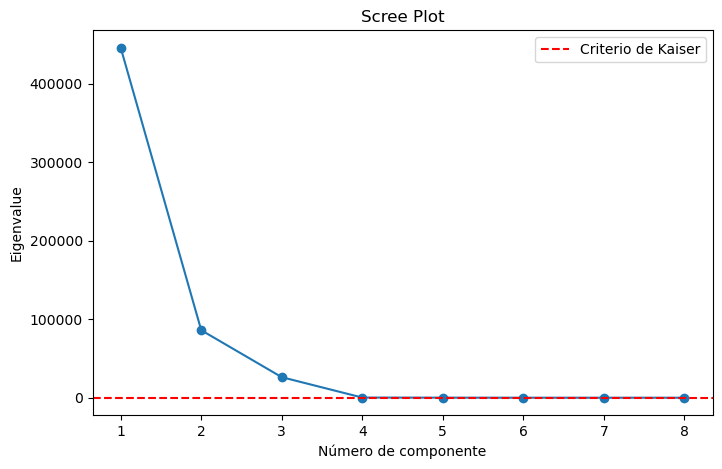

In [4]:
def perform_eigenvalues_and_plot(data, selected_columns):
    """
    PCA para extraer eigenvalores, criterio de Kaiser (>1) y scree plot.
    """
    import numpy as np
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    X = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64']).values
    pca = PCA()
    pca.fit(X)
    eigenvalues = pca.explained_variance_
    
    print("Eigenvalues:")
    for i, ev in enumerate(eigenvalues, 1):
        print(f"  Componente {i}: {ev:.4f}")
    
    n_factors = int(np.sum(eigenvalues > 1))
    print(f"\nNúmero de factores (Kaiser): {n_factors} {'(>0: adecuado)' if n_factors>0 else '(no adecuado)'}")
    
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='-')
    plt.axhline(y=1, color='red', linestyle='--', label='Criterio de Kaiser')
    plt.title('Scree Plot')
    plt.xlabel('Número de componente')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()
    
    return n_factors

_ = perform_eigenvalues_and_plot(CO2Data, selected_vars)


In [5]:
def get_factor_loadings(data, selected_columns, n_factors=None, rotation='varimax'):
    """
    Análisis factorial y matriz de cargas (loadings).
    Si n_factors es None, usa Kaiser para decidir.
    """
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
    from factor_analyzer import FactorAnalyzer

    # Datos numéricos sin NaNs
    df_num = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64'])

    if n_factors is None:
        pca = PCA().fit(df_num.values)
        eigenvalues = pca.explained_variance_
        n_factors = int(np.sum(eigenvalues > 1))
        print(f"Usando Kaiser: reteniendo {n_factors} factores")

    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)
    fa.fit(df_num.values)

    loadings = fa.loadings_
    loadings_df = pd.DataFrame(
        loadings, 
        index=df_num.columns, 
        columns=[f'Factor {i+1}' for i in range(n_factors)]
    )

    print("\nMatriz de cargas (loadings):")
    display(loadings_df.round(3))

    print("\nGuía rápida de interpretación:")
    print("- |loading| > 0.30: señal útil")
    print("- |loading| > 0.40: importante")
    print("- |loading| > 0.50: muy significativo")
    print("- El significado de cada factor lo sugieren las variables con mayores cargas en ese factor.")
    
    return loadings_df

loadings = get_factor_loadings(CO2Data, selected_vars, n_factors=2, rotation='varimax')



Matriz de cargas (loadings):


/Users/adua/miniconda3/envs/environmental_python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Factor 1,Factor 2
depth_m,-0.086,0.355
do_mg_l,0.138,-0.087
sal_psu,-0.428,0.499
turbidity_fnu,0.018,0.470
temp_c,0.112,-0.591
ta_micromol_kg,0.881,0.073
dic_micromol_kg,1.001,-0.149
chlorophy_microg_l,-0.047,0.327



Guía rápida de interpretación:
- |loading| > 0.30: señal útil
- |loading| > 0.40: importante
- |loading| > 0.50: muy significativo
- El significado de cada factor lo sugieren las variables con mayores cargas en ese factor.


In [8]:
def plot_fa_biplot(df, variables, group_col=None, label_col=None,
                   n_factors=2, title='Factor Analysis Biplot',
                   show_labels=True, save_path=None, figsize=(10, 10)):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib.patheffects import withStroke
    from sklearn.decomposition import FactorAnalysis
    from sklearn.preprocessing import StandardScaler

    # --- Filtrado y escalado ---
    X = df[variables].dropna()
    if X.empty or X.shape[0] < n_factors + 1:
        raise ValueError("No hay suficientes filas (tras dropna) para correr FA.")
    df_filtered = df.loc[X.index].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    # --- Factor Analysis ---
    fa = FactorAnalysis(n_components=n_factors, random_state=0)
    factor_scores = fa.fit_transform(X_scaled)        # (n_muestras, n_factors)
    loadings = fa.components_.T                       # (n_vars, n_factors)

    # --- Grupos / etiquetas ---
    groups = df_filtered[group_col].values if group_col else None
    labels = (df_filtered[label_col].astype(str).values
              if (label_col and label_col in df_filtered.columns)
              else np.array([""] * len(df_filtered)))
    unique_groups = np.unique(groups) if groups is not None else None
    cmap = matplotlib.cm.get_cmap('viridis', len(unique_groups) if unique_groups is not None else 1)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(0, color='lightgray', lw=1)
    ax.axvline(0, color='lightgray', lw=1)
    ax.add_artist(plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='dashed', alpha=0.5))

    # Vectores de carga (escalados para que se vean)
    arrow_scale = 2.5
    for i, var in enumerate(variables):
        x, y = loadings[i] * arrow_scale
        ax.arrow(0, 0, x, y, color='black', linewidth=2.0,
                 alpha=0.9, head_width=0.10, head_length=0.12,
                 zorder=3, length_includes_head=True)
        ax.text(x * 1.1, y * 1.1, var, fontsize=11, weight='bold',
                ha='center', va='center',
                path_effects=[withStroke(linewidth=3, foreground='white')],
                zorder=4)

    # Puntos (scores)
    if groups is not None:
        for i, g in enumerate(unique_groups):
            idx = (groups == g)
            ax.scatter(factor_scores[idx, 0], factor_scores[idx, 1],
                       s=55, alpha=0.85, edgecolors='white', linewidths=0.6,
                       facecolors=cmap(i), label=str(g), zorder=2)
            if show_labels:
                for j in np.where(idx)[0]:
                    ax.text(factor_scores[j, 0], factor_scores[j, 1], labels[j],
                            fontsize=6.5, alpha=0.6)
        ax.legend(title=group_col, fontsize=9, title_fontsize=10)
    else:
        ax.scatter(factor_scores[:, 0], factor_scores[:, 1],
                   s=55, alpha=0.85, edgecolors='white', linewidths=0.6,
                   facecolors=cmap(0), zorder=2)

    # Formato
    ax.set_xlabel('Factor 1', fontsize=13)
    ax.set_ylabel('Factor 2', fontsize=13)
    ax.set_title(title, fontsize=15, weight='bold')
    ax.tick_params(labelsize=11)
    ax.set_aspect('equal')

    # Límites cómodos
    margin = 0.5
    ax.set_xlim(factor_scores[:, 0].min() - margin, factor_scores[:, 0].max() + margin)
    ax.set_ylim(factor_scores[:, 1].min() - margin, factor_scores[:, 1].max() + margin)

    plt.tight_layout()

    if save_path:
        dpi = 600 if save_path.lower().endswith(('.png', '.jpg', '.jpeg')) else None
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()


/var/folders/1q/0d1wc4291_z5gfjdgg375t4m0000gn/T/ipykernel_4507/264810251.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis', len(unique_groups) if unique_groups is not None else 1)


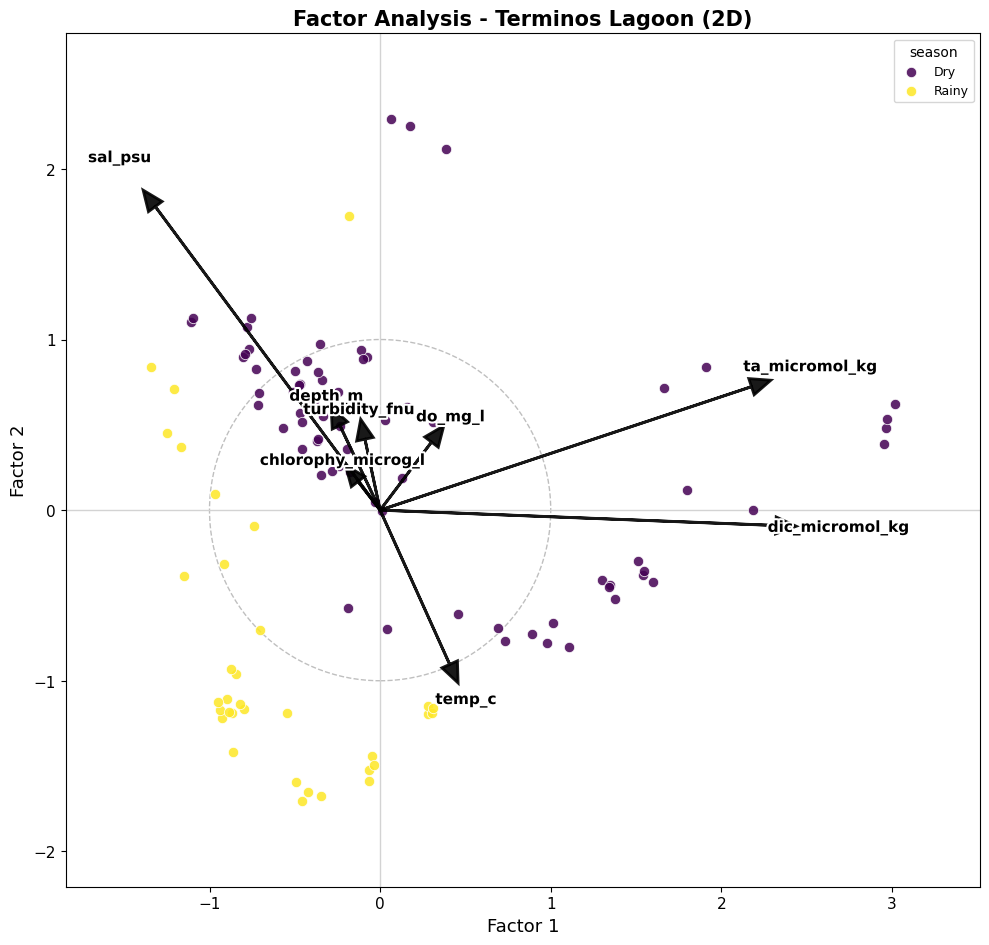

In [9]:
selected_vars = ['depth_m','do_mg_l','sal_psu','turbidity_fnu','temp_c','ta_micromol_kg','dic_micromol_kg','chlorophy_microg_l']

plot_fa_biplot(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='station',   # 'sample' no existe; 'station' sí
    n_factors=2,
    title='Factor Analysis - Terminos Lagoon (2D)',
    show_labels=False,
    save_path=None  # o "../output_files/fa_biplot_2d.png"
)


In [10]:
def plot_fa_biplot_3d(df, variables, group_col=None, label_col=None,
                      n_factors=3, title='3D Factor Analysis Biplot',
                      show_labels=False, save_path=None, elev=30, azim=120):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    from sklearn.decomposition import FactorAnalysis
    from sklearn.preprocessing import StandardScaler

    X = df[variables].dropna()
    if X.empty or X.shape[0] < n_factors + 1:
        raise ValueError("No hay suficientes filas (tras dropna) para correr FA 3D.")
    df_filtered = df.loc[X.index].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    fa = FactorAnalysis(n_components=n_factors, random_state=0)
    scores = fa.fit_transform(X_scaled)  # (n_muestras, n_factors)

    groups = df_filtered[group_col].values if group_col else None
    labels = (df_filtered[label_col].astype(str).values
              if (label_col and label_col in df_filtered.columns)
              else np.array([""] * len(df_filtered)))
    unique_groups = np.unique(groups) if groups is not None else None
    cmap = matplotlib.cm.get_cmap('viridis', len(unique_groups) if unique_groups is not None else 1)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    if groups is not None:
        for i, g in enumerate(unique_groups):
            idx = (groups == g)
            ax.scatter(scores[idx, 0], scores[idx, 1], scores[idx, 2],
                       s=45, alpha=0.85, edgecolors='white', linewidths=0.6,
                       facecolors=cmap(i), label=str(g))
            if show_labels:
                for j in np.where(idx)[0]:
                    ax.text(scores[j, 0], scores[j, 1], scores[j, 2],
                            labels[j], fontsize=6, alpha=0.6)
        ax.legend(title=group_col)
    else:
        ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2],
                   s=45, alpha=0.85, edgecolors='white', linewidths=0.6,
                   facecolors=cmap(0))

    ax.set_xlabel('Factor 1', fontsize=12)
    ax.set_ylabel('Factor 2', fontsize=12)
    ax.set_zlabel('Factor 3', fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()


/var/folders/1q/0d1wc4291_z5gfjdgg375t4m0000gn/T/ipykernel_4507/3120252296.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis', len(unique_groups) if unique_groups is not None else 1)


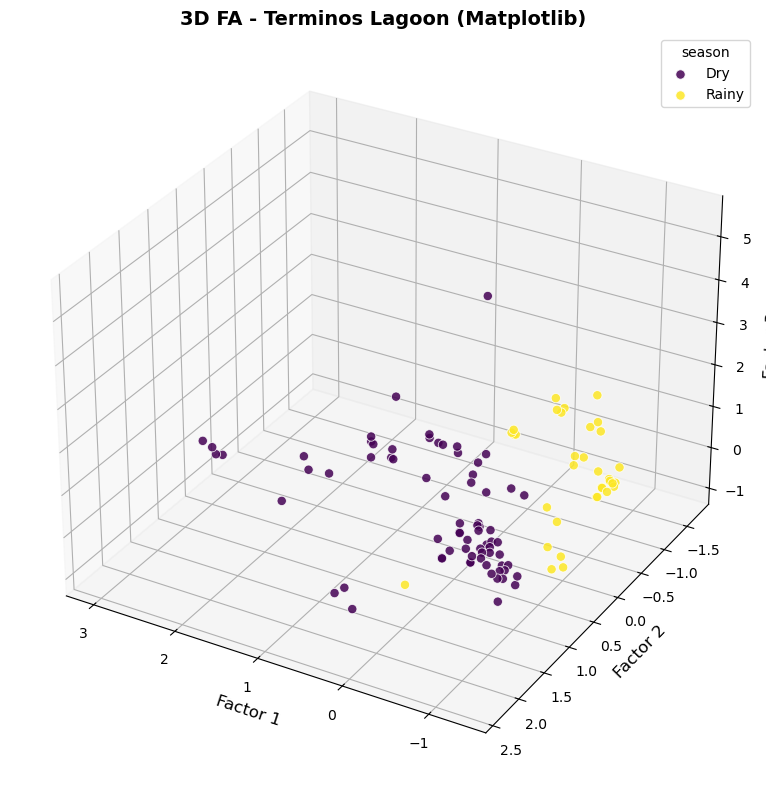

In [11]:
plot_fa_biplot_3d(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='station',
    n_factors=3,
    title='3D FA - Terminos Lagoon (Matplotlib)',
    show_labels=False,
    save_path=None  # o "../output_files/fa_biplot_3d_matplotlib.png"
)


In [12]:
def plot_fa_biplot_3d_plotly(df, variables, group_col=None, label_col=None,
                             n_factors=3, title='3D FA Interactive Biplot'):
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import FactorAnalysis
    from sklearn.preprocessing import StandardScaler
    import plotly.express as px

    X = df[variables].dropna()
    if X.empty or X.shape[0] < n_factors + 1:
        raise ValueError("No hay suficientes filas (tras dropna) para correr FA 3D.")
    df_filtered = df.loc[X.index].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    fa = FactorAnalysis(n_components=n_factors, random_state=0)
    scores = fa.fit_transform(X_scaled)

    for i in range(n_factors):
        df_filtered[f'Factor {i+1}'] = scores[:, i]

    if label_col and label_col in df_filtered.columns:
        df_filtered['_label'] = df_filtered[label_col].astype(str)
    else:
        df_filtered['_label'] = df_filtered.index.astype(str)

    fig = px.scatter_3d(
        df_filtered,
        x='Factor 1', y='Factor 2', z='Factor 3',
        color=group_col if group_col in df_filtered.columns else None,
        hover_name='_label',
        title=title,
        opacity=0.85,
        width=900, height=700
    )
    fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color='DarkSlateGrey')))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
    fig.show()


In [14]:
plot_fa_biplot_3d_plotly(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='station',
    n_factors=3,
    title='3D FA - Terminos Lagoon (Plotly)'
)
